In [49]:
#!/usr/bin/env python3
#SBATCH --cpus=1
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH --mail-type=ALL
#SBATCH --mail-user=abstreik
#SBATCH --time=18:00:00

In [50]:
import pandas as pd
import torch.nn as nn
import random
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import RotationMatrix
import time
from sklearn.model_selection import KFold
# from tqdm import tqdm_notebook as tqdm
tqdm = lambda x: x

In [51]:
points = pd.read_csv("rotated_points_angle.csv")

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_nodes = 5
        self.ff = nn.Sequential(
            nn.Linear(1, hidden_nodes),
            nn.Sigmoid(),
            nn.Linear(hidden_nodes, 1),
        )
    
    def forward(self, x_batch):
        return self.ff(x_batch)

## Check if model can learn sine function

In [53]:
def train_sin():
    random.seed(234)
    model = Net()
    opt = Adam(model.parameters())
    model.train()
    for i in tqdm(range(300000)):
        alpha = random.uniform(0, 2*math.pi)
        pred = model(torch.Tensor([alpha]))
        y_true = math.sin(alpha)
        opt.zero_grad()
        loss = (pred - y_true) ** 2
        loss.backward()
        opt.step()
    return model

In [54]:
def plot_sin_model(model):
    test = np.linspace(0, 2*math.pi, 100)
    model.eval()
    pred = model(torch.Tensor(np.matrix(test).transpose()))
    plt.plot(test, np.sin(test))
    plt.plot(test, pred.detach().numpy())
    plt.show()

In [55]:
# plot_sin_model(train_sin())

# Train nets for matrix

In [56]:
def get_loader(data):
    X = torch.FloatTensor(data[["x1", "y1", "alpha"]].values)
    y = torch.FloatTensor(data[["x2", "y2"]].values)
    torch_data = TensorDataset(X, y)
    loader = DataLoader(torch_data, batch_size=5, shuffle=False)
    return loader

In [57]:
def loss_fn(pred_x, pred_y, true_x, true_y):
    return (pred_x - true_x) ** 2 + (pred_y - true_y) ** 2

In [58]:
def calc_pred_loss(x_batch, y_batch, nets):
    alphas = x_batch[:, [2]]
    matrix_entries = [model(alphas) for model in nets]
    loss = 0
    preds = []
    for i in range(len(alphas)):
        predx = matrix_entries[0][i] * x_batch[i][0] + matrix_entries[1][i] * x_batch[i][1]
        predy = matrix_entries[2][i] * x_batch[i][0] + matrix_entries[3][i] * x_batch[i][1]
        loss += loss_fn(predx, predy, y_batch[i][0], y_batch[i][1])
        preds.append((predx.item(), predy.item()))
    loss /= len(alphas)
    return {"loss": loss, "preds": preds}

In [59]:
def calc_loss(x_batch, y_batch, nets):
    return calc_pred_loss(x_batch, y_batch, nets)["loss"]

In [60]:
# build test set
n_test = 16
test = []
for alpha in np.linspace(0, 2*math.pi, n_test+1)[:-1]:
    x1, y1 = RotationMatrix.apply_rotation(1, 0, alpha)
    x2, y2 = RotationMatrix.apply_rotation(x1, y1, alpha)
    test.append([alpha, x1, y1, x2, y2])
test = pd.DataFrame(test, columns=['alpha', 'x1', 'y1', 'x2', 'y2'])
test_loader = get_loader(test)

In [61]:
def test(net_ensemble):
    test_preds = []
    test_true = []
    all_model_preds = []
    for nets in net_ensemble:
        model_preds = []
        for x_batch, y_batch in test_loader:
            result = calc_pred_loss(x_batch, y_batch, nets)
            model_preds += result["preds"]
            test_true += list(y_batch)
        all_model_preds.append(model_preds)
    for i in range(len(all_model_preds[0])):
        predx = 0
        predy = 0
        for model_preds in all_model_preds:
            predx += model_preds[i][0]
            predy += model_preds[i][1]
        predx /= len(all_model_preds)
        predy /= len(all_model_preds)
        test_preds.append((predx, predy))
    test_loss = 0
    for y_pred, y_true in zip(test_preds, test_true):
        test_loss += loss_fn(y_pred[0], y_pred[1], y_true[0], y_true[1])
    test_loss /= len(test_preds)
    return {"loss": test_loss.item(), "preds": test_preds}

In [ ]:
def train(n_points_train_val, includeTests=False, prints=False):
    train_val_points = points.head(n_points_train_val)
    n_folds = min(n_points_train_val, 5)
    fold_indices = [([0], [0])]
    if n_points_train_val > 1:
        kf = KFold(n_folds)
        fold_indices = kf.split(train_val_points)
        
    train_loader = []
    val_loader = []
    for train_index, val_index in fold_indices:
        train_loader.append(get_loader(points.loc[train_index]))
        val_loader.append(get_loader(points.loc[val_index]))
    
    nets = [[Net() for _ in range(4)] for _ in range(n_folds)]
    opts = [[Adam(model.parameters()) for model in matrixnets] for matrixnets in nets]
    val_losses = []
    train_losses = []
    test_losses = []
    best_test_preds = None
    epochs = []
    epoch = 0
    epochs_per_validation = 100 if n_points_train_val > 10 else (10 if n_points_train_val > 5 else 3)
    while True:
        epoch_val_loss = 0
        epoch_train_loss = 0
        validate = (epoch % epochs_per_validation == 0)
        for fold in range(n_folds):
            # training
            for model in nets[fold]:
                model.train()
            for x_batch, y_batch in train_loader[fold]:
                loss = calc_loss(x_batch, y_batch, nets[fold])
                for opt in opts[fold]:
                    opt.zero_grad()
                loss.backward()
                for opt in opts[fold]:
                    opt.step()
            # validation
            if validate:
                for model in nets[fold]:
                    model.eval()
                val_loss = 0
                train_loss = 0
                for x_batch, y_batch in val_loader[fold]:
                    val_loss += calc_loss(x_batch, y_batch, nets[fold])
                for x_batch, y_batch in train_loader[fold]:
                    train_loss += calc_loss(x_batch, y_batch, nets[fold])
                val_loss /= len(val_loader[fold])
                train_loss /= len(train_loader[fold])
                epoch_val_loss += val_loss
                epoch_train_loss += train_loss

        if validate:
            epochs.append(epoch)
            epoch_val_loss /= n_folds
            epoch_train_loss /= n_folds
            val_losses.append(epoch_val_loss.item())
            train_losses.append(epoch_train_loss.item())
            if includeTests:
                test_result = test(nets)
                test_losses.append(test_result["loss"])
                if len(val_losses) > 1 and (best_test_preds is None or val_losses[-1] < min(val_losses[1:-1])):
                    best_test_preds = test_result["preds"]
        if prints and epoch % 100 == 0:
            print("Epoch {}:\tTrain {}\tVal {}\tTest {}".format(epoch, train_losses[-1], val_losses[-1], test_losses[-1]))
        epoch += 1
        reference_loss_index = 1000 // epochs_per_validation
        if epoch > max(n_points_train_val * 200, 2000) and val_losses[-1] >= val_losses[-reference_loss_index]:
            break
    
    return {"nets": nets, 
            "train_loss": train_losses, 
            "val_loss": val_losses, 
            "test_loss": test_losses, 
            "best_test_preds": best_test_preds,
            "epochs": epochs
           }

In [63]:
def visualize_train(train_result):
    plt.plot(train_result["epochs"], train_result["val_loss"], label='Validation')
    plt.plot(train_result["epochs"], train_result["train_loss"], label='Training')
    if len(train_result["test_loss"]):
        plt.plot(train_result["epochs"], train_result["test_loss"], label='Test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

Start calculation for 1 points.
Epoch 0:	Train 1.1195111274719238	Val 1.1195111274719238	Test 1.1090490818023682
Epoch 100:	Train 0.1670507788658142	Val 0.1670507788658142	Test 1.2835111618041992
Epoch 200:	Train 0.006902850698679686	Val 0.006902850698679686	Test 1.5200390815734863
Epoch 300:	Train 1.9171762687619776e-05	Val 1.9171762687619776e-05	Test 1.5908992290496826
Epoch 400:	Train 1.681656591756564e-09	Val 1.681656591756564e-09	Test 1.5949312448501587
Epoch 500:	Train 1.4210854715202004e-14	Val 1.4210854715202004e-14	Test 1.594969630241394
Epoch 600:	Train 1.4210854715202004e-14	Val 1.4210854715202004e-14	Test 1.594969630241394
Epoch 700:	Train 1.4210854715202004e-14	Val 1.4210854715202004e-14	Test 1.5949695110321045
Epoch 800:	Train 3.552713678800501e-15	Val 3.552713678800501e-15	Test 1.5949695110321045
Epoch 900:	Train 3.552713678800501e-15	Val 3.552713678800501e-15	Test 1.5949695110321045
Epoch 1000:	Train 3.552713678800501e-15	Val 3.552713678800501e-15	Test 1.594969511032104

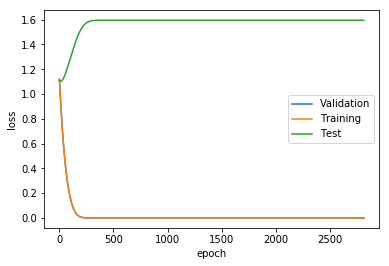

In [72]:
results = []
for n_points_train_val in [10]:# range(1, 31):
    print("Start calculation for {} points.".format(n_points_train_val))
    starttime = time.time()
    train_result = train(n_points_train_val, includeTests=True, prints=False)
    # visualize_train(train_result)
    del train_result["nets"]
    results.append([n_points_train_val, str(train_result), time.time() - starttime])
    if n_points_train_val >= 10 and n_points_train_val % 5 == 0:
        df = pd.DataFrame(results, columns=["n_points_train_val", "train_result", "execution_time"])
        df.to_csv("train_limited_data_results_{}.csv".format(n_points_train_val), index=False)

In [73]:
print("Finished")

Finished
